In [19]:
!pip install catboost
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
df = pd.read_csv(r'drive/MyDrive/Skripsi/citarum.csv')

In [22]:
#Dropping unnecessary columns
cols_to_drop = ['Measuring_Point', 'Date', 'Temperatur', 'Debit']
df = df.drop(cols_to_drop, axis=1)
df.head(3)

,TDS,TSS,NH3,Surfactant,Phenol,Phospate,BOD,COD,OG,NO3,DO,pH,Cl3,Fecal_Coliform,Total_Coliform,Class
0,81.0,35.0,0.025,740.0,40.0,0.040,3.89,18.41,1000.0,1.12,7.04,7.79,0.01,24000,30000,4
1,254.0,20.0,0.060,60.0,1.0,0.006,0.16,0.49,1000.0,0.17,6.72,7.13,0.01,80000,110000,4
2,208.0,61.0,0.040,60.0,1.0,0.060,2.81,5.76,1000.0,1.76,5.77,6.77,0.01,160000,160000,4


In [23]:
#Seperating X & y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [24]:
#Splitting test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 29)

In [25]:
#Feature selection with Mutual Information
from sklearn.feature_selection import SelectKBest,mutual_info_classif
mic = SelectKBest(score_func=mutual_info_classif,k=5)
X_train = mic.fit_transform(X_train, y_train)

feature_idx = mic.get_support(indices=True)
feature_names = df.columns[feature_idx]

# creating selected features dataframe with corresponding column names
features = pd.DataFrame(X_train, columns=feature_names)

feature_MI_score = pd.Series(mic.scores_)
display(feature_MI_score)
display(mic.get_support())
display(features.head())

0     0.093207
1     0.000000
2     0.186764
3     0.076170
4     0.127675
5     0.049890
6     0.022689
7     0.010958
8     0.086132
9     0.099295
10    0.055426
11    0.005383
12    0.065274
13    0.078902
14    0.081625
dtype: float64

array([ True, False,  True, False,  True, False, False, False,  True,
        True, False, False, False, False, False])

,TDS,NH3,Phenol,OG,NO3
0,86.86,0.080,3.400,2000.0,39.400
1,672.00,4.910,40.000,1000.0,1.810
2,208.00,1.030,1.000,200.0,1.250
3,214.50,0.015,0.001,1.0,1.247
4,368.00,0.200,1.000,3420.0,0.100


In [26]:
#Applying data standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [27]:
import numpy as np
display(np.bincount(y))
display(np.bincount(y_train))
display(np.bincount(y_test))

array([  3,   2,   2,  13, 147])

array([  2,   1,   1,  10, 102])

array([ 1,  1,  1,  3, 45])

In [28]:
#Apply Naive ROS and create new X_train & y_train
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [29]:
display(np.bincount(y))
display(np.bincount(y_train))
display(np.bincount(y_test))

array([  3,   2,   2,  13, 147])

array([102, 102, 102, 102, 102])

array([ 1,  1,  1,  3, 45])

In [30]:
#Empty result dataframe
res = pd.DataFrame(index=['precision','recall','f1-score','accuracy'])

In [31]:
#Result Function
def result(clf, Classifier_Name):
  #Model Fitting
  clf.fit(X_train, y_train)
  
  #Showing performance result
  X_test_mic = mic.transform(X_test)
  X_test_sc = sc.transform(X_test_mic)
  y_pred=clf.predict(X_test_sc)
  from sklearn.metrics import classification_report
  clf_res = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
  
  #Append classifier result to result DataFrame
  res[str(Classifier_Name)] = [clf_res['weighted avg']['precision'],
                               clf_res['weighted avg']['recall'], 
                               clf_res['weighted avg']['f1-score'], 
                               clf_res['accuracy']]
  display(res)

  #Creating confusion matrix illustration
  from sklearn.metrics import ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test_sc, y_test, xticks_rotation="vertical", 
    display_labels=['Unsuitable', 'Very Poor', 'Poor', 'Good', 'Excellent'])
  disp.ax_.set_title("Confusion Matrix for " + str(Classifier_Name) + " Classifier")

,Decision Tree
precision,0.873828
recall,0.901961
f1-score,0.887093
accuracy,0.901961


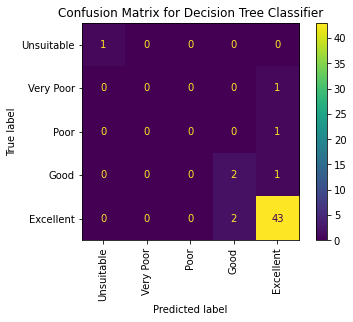

In [32]:
#Using Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
result(dt_clf, "Decision Tree")

,Decision Tree,Random Forest
precision,0.873828,0.861408
recall,0.901961,0.862745
f1-score,0.887093,0.858706
accuracy,0.901961,0.862745


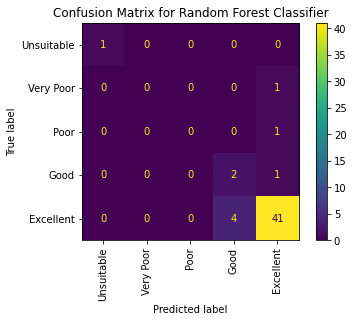

In [33]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
result(rf_clf, "Random Forest")

,Decision Tree,Random Forest,SVM,Naive Bayes,CatBoost
precision,0.873828,0.861408,0.876751,0.898248,0.839940
recall,0.901961,0.862745,0.843137,0.882353,0.862745
f1-score,0.887093,0.858706,0.854496,0.885383,0.850894
accuracy,0.901961,0.862745,0.843137,0.882353,0.862745


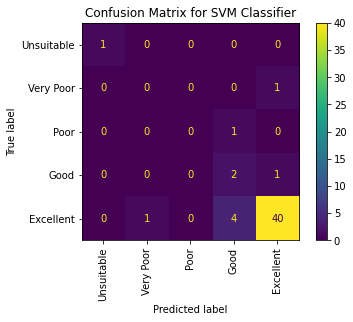

In [38]:
# Using Kernel SVM Classifier
from sklearn.svm import SVC
svm_clf = SVC(kernel = 'rbf', random_state = 0)
result(svm_clf, "SVM")

,Decision Tree,Random Forest,SVM,Naive Bayes
precision,0.873828,0.861408,0.876751,0.898248
recall,0.901961,0.862745,0.843137,0.882353
f1-score,0.887093,0.858706,0.854496,0.885383
accuracy,0.901961,0.862745,0.843137,0.882353


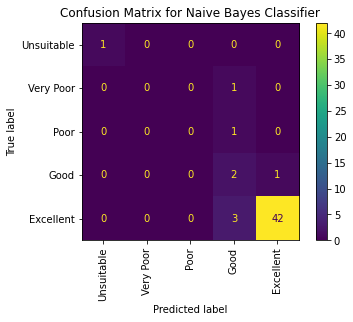

In [35]:
# Using Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
result(nb_clf, "Naive Bayes")

,Decision Tree,Random Forest,SVM,Naive Bayes,CatBoost
precision,0.873828,0.861408,0.876751,0.898248,0.839940
recall,0.901961,0.862745,0.843137,0.882353,0.862745
f1-score,0.887093,0.858706,0.854496,0.885383,0.850894
accuracy,0.901961,0.862745,0.843137,0.882353,0.862745


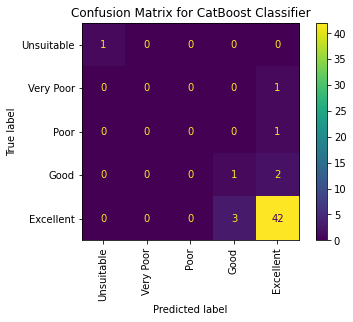

In [36]:
# Using CatBoost Classifier
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier(random_seed=42, logging_level='Silent')
result(cb_clf, "CatBoost")